In [2]:
import numpy as np
import matplotlib.pyplot as plt

# American Option as an Integral Equation

## Solving for the optimal exercise boundary

### The Integral Equation

$$
S_f(t) - K = M_1(S_f(t), T-t, K) + \int_t^{T}Q_1(S_f(t), t, u, S_f(u)) du
$$

$$
Q_1(x,y,z,w) = x\delta e^{-\delta(z - y)} \Phi(d_1(x, z-y, w))
- rKe^{-r(z-y)}\Phi(d_2(x, z-y, w))
$$

$$
M_1(x,y,z) = xe^{-\delta y} \Phi (d_1(x,y,z)) - z e^{-ry}\Phi(d_2(x,y,z))
$$

$$
d_1(x, y, z) = \frac{\ln(x/z) + (r - \delta + \sigma^2/2)y}{\sigma\sqrt{y}}
$$

$$
d_2(x, y, z) = d_1(x,y,z)-\sigma\sqrt{y}
$$

$$
1_{(S=S_f)}(S) =
\begin{cases}
\frac{1}{2} & \textrm{if } S = S_f(t) \\ 
0 & \textrm{otherwise}
\end{cases}
$$

### Parameters

In [2]:
dividend = 0.02
strike_price = 100
volatility = 0.2
risk_free_rate = 0.05
time_to_maturity = 1

### Computation of necessary functions

In [6]:
from scipy.special import erf

# The CDF of the standard normal distribution
def phi(z):
    return (1.0 + erf(z / np.sqrt(2.0))) / 2.0

# The PDF of the standard normal distribution
def small_phi(z):
    return np.exp(-0.5 * z ** 2) / np.sqrt(2 * np.pi)

def d1(x, y, z):
    return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))

def d2(x, y, z):
    return d1(x, y, z) - volatility * np.sqrt(y)

def Q1(x, y, z, w):
    x = float(x)
    result = x * dividend * np.exp(-dividend * (z - y)) * phi(d1(x, z - y, w))
    result -= risk_free_rate * strike_price * np.exp(-risk_free_rate * (z - y)) * phi(d2(x, z - y, w))
    return result

# def Q1_derivative_x(x, y, z, w):
#     # Derivative of Q1 with respect to x using five-point stencil method
#     h = 1e-5
#     return (-Q1(x + 2*h, y, z, w) + 8*Q1(x + h, y, z, w) - 8*Q1(x - h, y, z, w) + Q1(x - 2*h, y, z, w)) / (12 * h)

def Q1_derivative_x(x, y, z, w):
    result = dividend * np.exp(-dividend * (z - y)) * phi(d1(x, z - y, w))
    result += dividend * np.exp(-dividend * (z - y)) * small_phi(d1(x, z - y, w)) / (volatility * np.sqrt(z - y))
    result -= risk_free_rate * strike_price * np.exp(-risk_free_rate * (z - y)) * small_phi(d2(x, z - y, w)) / (volatility * x * np.sqrt(z - y))
    return result

def M1(x, y, z):
    x = float(x)
    result = x * np.exp(-dividend * y) * phi(d1(x, y, z)) - strike_price * np.exp(-risk_free_rate * y) * phi(d2(x, y, z))
    return result

# def M1_derivative_x(x, y, z):
#     # Derivative of M1 with respect to x using five-point stencil method
#     h = 1e-5
#     return (-M1(x + 2*h, y, z) + 8*M1(x + h, y, z) - 8*M1(x - h, y, z) + M1(x - 2*h, y, z)) / (12 * h)

def M1_derivative_x(x, y, z):
    result = np.exp(-dividend * y) * phi(d1(x, y, z))
    result += np.exp(-dividend * y) * small_phi(d1(x, y, z)) / (volatility * np.sqrt(y))
    result -= z * np.exp(-risk_free_rate * y) * small_phi(d2(x, y, z)) / (volatility * x * np.sqrt(y))

    return result

### The Newton Raphson procedure

In [7]:
# Newton-Raphson method
def newton_raphson(f, f_prime, x0, tol=1e-8, max_iter=100):
    x = x0
    n_iter = 0
    for _ in range(max_iter):
        n_iter += 1
        fx = f(x)
        fpx = f_prime(x)
        if abs(fpx) < tol:
            raise ValueError("Derivative too small; no convergence.")
        x_new = x - fx / fpx
        if abs(x_new - x) < tol:
            return [x_new, n_iter]
        x = x_new
    print(f"Did not converge in {max_iter} iterations.")
    return [x, n_iter]

### Computing the solution

In [8]:
time_discretization = np.linspace(0, time_to_maturity, 252)
s_f_list = []
s_f_list.append([0] * len(time_discretization))
s_f_list = s_f_list[0]

s_f_list[-1] = max(strike_price, risk_free_rate * strike_price / dividend)
n_steps = len(time_discretization) - 1
cnt=0
n_steps_to_convergence = []
for i in range(len(time_discretization) - 2, -1, -1):
    time_passed = i / n_steps
    guess_x = s_f_list[i + 1] 
    def test_sf(x):
        test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
        test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
        for j in range(i + 1, len(time_discretization) - 1, 1):
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j])
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return test_result
    def test_sf_derivative(x):
        derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
        derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
        for j in range(i + 1, len(time_discretization) - 1):
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j])
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return derivative_result
    
    newton_raphson_result = newton_raphson(test_sf, test_sf_derivative, guess_x, max_iter=10)
    s_f_list[i] = newton_raphson_result[0]
    n_steps_to_convergence.append(newton_raphson_result[1])

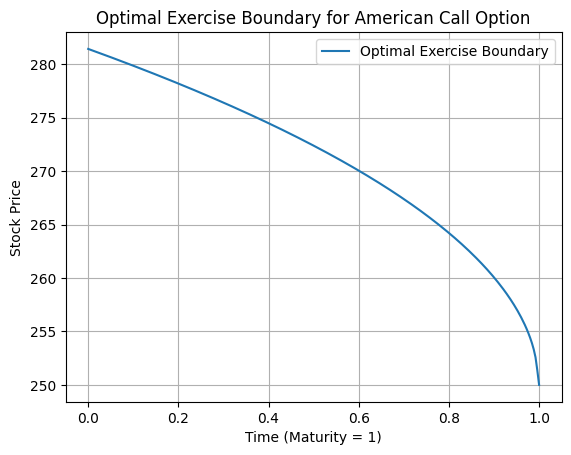

In [31]:
# Graph the stock price and the optimal exercise boundary
plt.plot(time_discretization, s_f_list, label='Optimal Exercise Boundary')
plt.legend()
plt.xlabel('Time (Maturity = 1)')
plt.ylabel('Stock Price')
plt.title('Optimal Exercise Boundary for American Call Option')
plt.grid()
# Save as PNG file in /images folder
plt.savefig('images/optimal_exercise_boundary.png', dpi=300, bbox_inches='tight')
plt.show()

## Convergence analysis

Here, we plot the distribution of the number of steps needed for Newton Raphson procedures to converge.

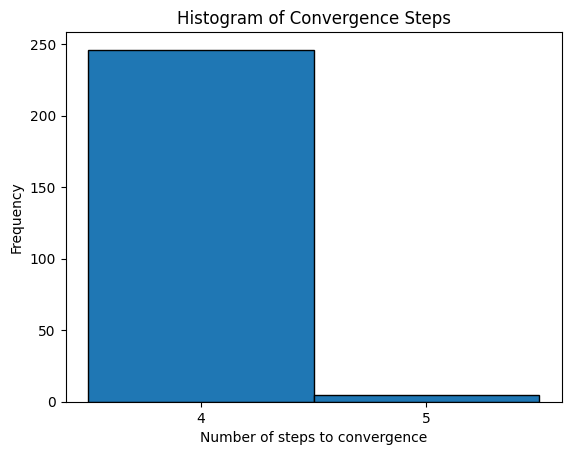

In [14]:
# Convert n_steps_to_convergence to a NumPy array
n_steps_to_convergence_array = np.array(n_steps_to_convergence)

# Assuming n_steps_to_convergence is a NumPy array of integer values:
min_val = n_steps_to_convergence_array.min()
max_val = n_steps_to_convergence_array.max()

# Create bins that cover each integer value. The -0.5 and +0.5 ensure that the bin is centered on the integer.
bins = np.arange(min_val - 0.5, max_val + 1.5, 1)

plt.hist(n_steps_to_convergence_array, bins=bins, edgecolor='black')
plt.xticks(np.arange(min_val, max_val + 1))  # Set x-ticks to integer values
plt.xlabel('Number of steps to convergence')
plt.ylabel('Frequency')
plt.title('Histogram of Convergence Steps')
plt.show()

In qualitative terms, quadratic convergence means that each iteration typically doubles the number of correct digits. Since our tolerance is set at $10^{-8}$, about four iterations are required to achieve this level of precision, which strongly indicates that our convergence is indeed quadratic.

### What if the number of discretization decreases?

In [15]:
time_discretization = np.linspace(0, time_to_maturity, 32)
s_f_list = []
s_f_list.append([0] * len(time_discretization))
s_f_list = s_f_list[0]

s_f_list[-1] = max(strike_price, risk_free_rate * strike_price / dividend)
n_steps = len(time_discretization) - 1
cnt=0
n_steps_to_convergence = []
for i in range(len(time_discretization) - 2, -1, -1):
    time_passed = i / n_steps
    guess_x = s_f_list[i + 1] 
    def test_sf(x):
        test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
        test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
        for j in range(i + 1, len(time_discretization) - 1, 1):
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j])
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return test_result
    def test_sf_derivative(x):
        derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
        derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
        for j in range(i + 1, len(time_discretization) - 1):
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j])
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return derivative_result
    
    newton_raphson_result = newton_raphson(test_sf, test_sf_derivative, guess_x)
    s_f_list[i] = newton_raphson_result[0]
    n_steps_to_convergence.append(newton_raphson_result[1])

Text(0.5, 0, 'Time (Maturity = 1)')

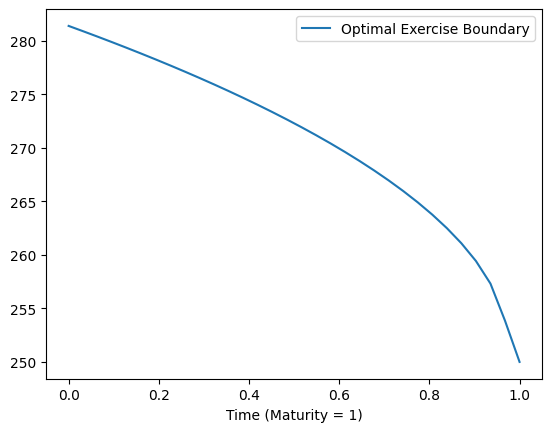

In [16]:
# Graph the stock price and the optimal exercise boundary
plt.plot(time_discretization, s_f_list, label='Optimal Exercise Boundary')
plt.legend()
plt.xlabel('Time (Maturity = 1)')

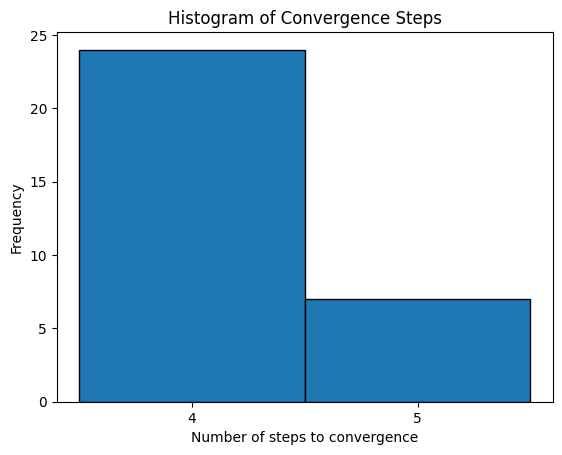

In [17]:
# Convert n_steps_to_convergence to a NumPy array
n_steps_to_convergence_array = np.array(n_steps_to_convergence)

# Assuming n_steps_to_convergence is a NumPy array of integer values:
min_val = n_steps_to_convergence_array.min()
max_val = n_steps_to_convergence_array.max()

# Create bins that cover each integer value. The -0.5 and +0.5 ensure that the bin is centered on the integer.
bins = np.arange(min_val - 0.5, max_val + 1.5, 1)

plt.hist(n_steps_to_convergence_array, bins=bins, edgecolor='black')
plt.xticks(np.arange(min_val, max_val + 1))  # Set x-ticks to integer values
plt.xlabel('Number of steps to convergence')
plt.ylabel('Frequency')
plt.title('Histogram of Convergence Steps')
plt.show()

As we can see, even the number of discretization is 3, the Newton Raphson still converges. This means that even when the distance between the root and the initial guess is super far, we still have convergence (perhaps even quadratic). Therefore, it is likely that the function $f$ that we are finding the root has very nice property

### The plot of $f$

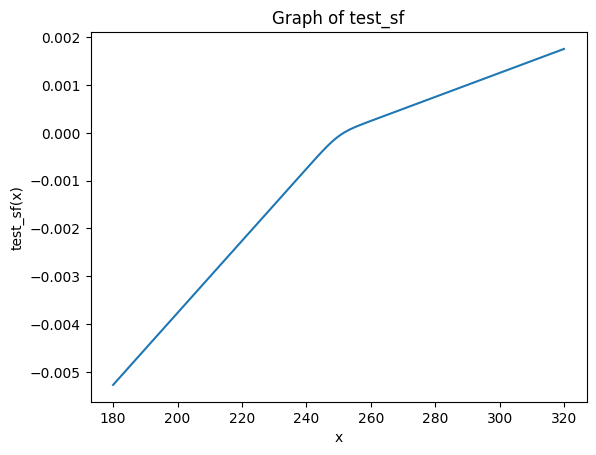

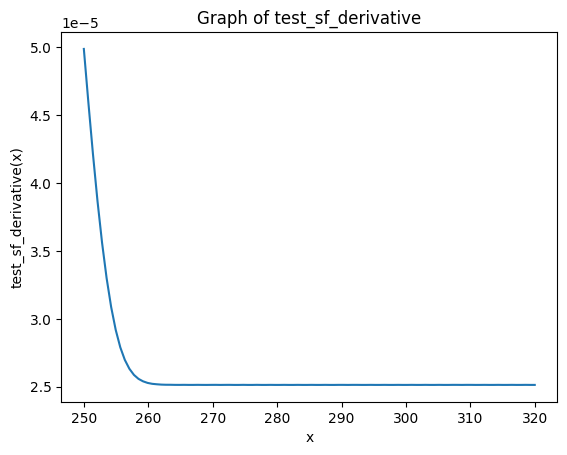

In [18]:
time_discretization = np.linspace(0, time_to_maturity, 200)
s_f_list = []
s_f_list.append([0] * len(time_discretization))
s_f_list = s_f_list[0]

s_f_list[-1] = max(strike_price, risk_free_rate * strike_price / dividend)
n_steps = len(time_discretization) - 1
cnt=0
n_steps_to_convergence = []
for i in range(len(time_discretization) - 2, -1, -1):
    time_passed = i / n_steps
    guess_x = s_f_list[i + 1] 
    def test_sf(x):
        test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
        test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
        for j in range(i + 1, len(time_discretization) - 1, 1):
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j])
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return test_result
    def test_sf_derivative(x):
        derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
        derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
        for j in range(i + 1, len(time_discretization) - 1):
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j])
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return derivative_result
    
    if (i == 198):
        # Plot the graph of test_sf
        x_values = np.linspace(180, 320, 100)
        y_values = [test_sf(x) for x in x_values]
        plt.plot(x_values, y_values)
        plt.xlabel('x')
        plt.ylabel('test_sf(x)')
        plt.title('Graph of test_sf')
        plt.show()
        
        #Plot the graph of test_sf_derivative
        x_values = np.linspace(250, 320, 100)
        y_values = [test_sf_derivative(x) for x in x_values]
        plt.plot(x_values, y_values)
        plt.xlabel('x')
        plt.ylabel('test_sf_derivative(x)')
        plt.title('Graph of test_sf_derivative')
        plt.show()
        break
    newton_raphson_result = newton_raphson(test_sf, test_sf_derivative, guess_x)
    s_f_list[i] = newton_raphson_result[0]
    n_steps_to_convergence.append(newton_raphson_result[1])

We can clearly see that our function $f$ is concave. From the theoretical result, we can prove that the convergence of Newton-Raphson method is unconditionally guaranteed.

### Verify the convergence rate

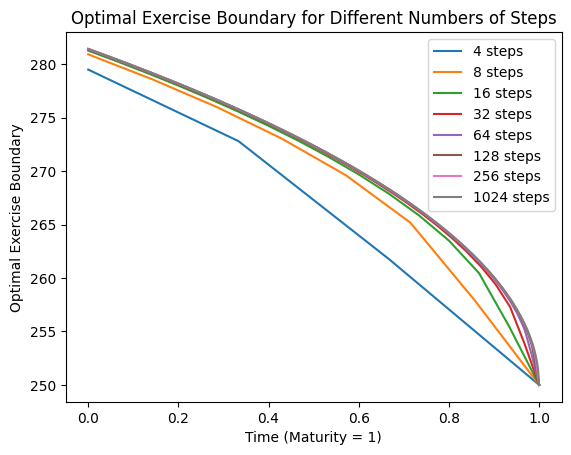

In [9]:
def test_by_n_discretizations(n_discretizations):
    time_discretization = np.linspace(0, time_to_maturity, n_discretizations)
    s_f_list = []
    for _ in range(len(time_discretization)):
        s_f_list.append([0, 0])  # Create a new list for each pair

    s_f_list[-1][1] = max(strike_price, risk_free_rate * strike_price / dividend)
    s_f_list[-1][0] = time_discretization[-1]

    n_steps = len(time_discretization) - 1
    n_steps_to_convergence = []
    for i in range(len(time_discretization) - 2, -1, -1):
        time_passed = i / n_steps
        guess_x = s_f_list[i + 1][1]
        def test_sf(x):
            test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1][1])
            test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
            for j in range(i + 1, len(time_discretization) - 1, 1):
                test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j][1])
                test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1][1])
            return test_result
        def test_sf_derivative(x):
            derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
            derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1][1])
            derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
            for j in range(i + 1, len(time_discretization) - 1):
                derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j][1])
                derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1][1])
            return derivative_result
        
        newton_raphson_result = newton_raphson(test_sf, test_sf_derivative, guess_x)
        s_f_list[i][1] = newton_raphson_result[0]
        s_f_list[i][0] = time_discretization[i]
        n_steps_to_convergence.append(newton_raphson_result[1])
    return s_f_list

test_sizes = [4, 8, 16, 32, 64, 128, 256, 1024]
test_results = []
for (i, test_size) in enumerate(test_sizes):
    test_results.append(test_by_n_discretizations(test_size))
    plt.plot([x[0] for x in test_results[i]], [x[1] for x in test_results[i]], label=f'{test_size} steps')
plt.legend()
plt.xlabel('Time (Maturity = 1)')
plt.ylabel('Optimal Exercise Boundary')
plt.title('Optimal Exercise Boundary for Different Numbers of Steps')
# Save the image to the /images folder
plt.savefig('images/optimal_exercise_boundary_different_steps.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
import numpy as np

def compute_errors(curve, ground_truth):
    """
    Compute L1, L2, and Linf errors between 'curve' and 'ground_truth'.
    Both are lists of [time, boundary] pairs. Interpolates curve to GT times.
    Returns (E1, E2, Einf).
    """
    # Ground truth arrays
    t_gt = np.array([pt[0] for pt in ground_truth])
    b_gt = np.array([pt[1] for pt in ground_truth])
    # Curve arrays
    t_c  = np.array([pt[0] for pt in curve])
    b_c  = np.array([pt[1] for pt in curve])
    # Interpolate numerical boundary onto GT time grid
    b_interp = np.interp(t_gt, t_c, b_c)
    diff = b_interp - b_gt

    E1   = np.mean(np.abs(diff))                   # L1
    E2   = np.sqrt(np.mean(diff**2))              # L2 (RMS)
    Einf = np.max(np.abs(diff))                   # Linf
    return E1, E2, Einf

# Example data structures
# test_results = [...]   # list of results arrays for each test_size
# test_sizes   = [...]   # [32, 64, 128, 256, 512, 1024]
ground_truth = test_results[-1]

# Containers
errors = []   # list of (E1, E2, Einf)

# Compute errors
for i, N in enumerate(test_sizes):
    if N == test_sizes[-1]:
        # zero error for GT itself
        errors.append((0.0, 0.0, 0.0))
    else:
        E1, E2, Einf = compute_errors(test_results[i], ground_truth)
        errors.append((E1, E2, Einf))

rates = [np.nan]  # first row has no predecessor
for i in range(1, len(test_sizes)):
    E1_prev = errors[i-1][0]
    E1_curr = errors[i][0]
    # avoid division by zero
    if E1_curr > 0:
        rates.append(E1_prev / E1_curr)
    else:
        rates.append(np.nan)

# Print table with the new Rate column
print(f"{'Steps':>6}  {'E1 (mean)':>12}  {'E2 (rms)':>12}  {'Einf':>12}  {'Rate':>10}")
for N, (E1, E2, Einf), r in zip(test_sizes, errors, rates):
    print(f"{N:6d}  {E1:12.4e}  {E2:12.4e}  {Einf:12.4e}  {r:10.4f}")


 Steps     E1 (mean)      E2 (rms)          Einf        Rate
     4    4.6251e+00    4.9744e+00    7.1533e+00         nan
     8    1.6725e+00    2.1353e+00    4.5792e+00      2.7654
    16    6.2913e-01    9.8365e-01    3.0863e+00      2.6584
    32    2.4022e-01    4.6816e-01    2.1224e+00      2.6190
    64    9.1417e-02    2.2492e-01    1.4655e+00      2.6277
   128    3.3979e-02    1.0638e-01    9.9625e-01      2.6904
   256    1.1803e-02    4.7082e-02    6.3573e-01      2.8788
  1024    0.0000e+00    0.0000e+00    0.0000e+00         nan


In [39]:
# Play around, using trapezoidal rule to compute the integral of the function
def trapezoidal_rule(f, a, b, n):
    """
    Compute the integral of f from a to b using the trapezoidal rule with n intervals.
    """
    h = (b - a) / n
    integral = 0.5 * (f(a) + f(b))
    for i in range(1, n):
        integral += f(a + i * h)
    return integral * h

# Example function to integrate
def example_function(x):
    return np.sin(x)  # Example function

# Integration limits and number of intervals
a = 0
b = np.pi
n_intervals = 1000
result = trapezoidal_rule(example_function, a, b, n_intervals)
print(f"Integral of sin(x) from {a} to {b} is approximately: {result:.4f}")

# Compute the convergence rate of the trapezoidal rule, trying different numbers of intervals
n_intervals_list = [10, 20, 40, 80, 160, 320]
errors = []  # List to store errors for each number of intervals
for n in n_intervals_list:
    integral_approx = trapezoidal_rule(example_function, a, b, n)
    error = abs(integral_approx - result)  # Error compared to the exact result
    errors.append(error)

# Compute convergence rates
convergence_rates = [np.nan]  # First entry has no predecessor
for i in range(1, len(errors)):
    if errors[i] > 0:
        rate = errors[i-1] / errors[i]
    else:
        rate = np.nan
    convergence_rates.append(rate)

# Print the errors and convergence rates
print(f"{'Intervals':>10}  {'Error':>12}  {'Rate':>10}")
for n, error, rate in zip(n_intervals_list, errors, convergence_rates):
    print(f"{n:10d}  {error:12.4e}  {rate:10.4f}")
# The above code computes the integral of sin(x) from 0 to pi using the trapezoidal rule and prints the result.

Integral of sin(x) from 0 to 3.141592653589793 is approximately: 2.0000
 Intervals         Error        Rate
        10    1.6475e-02         nan
        20    4.1124e-03      4.0061
        40    1.0265e-03      4.0060
        80    2.5538e-04      4.0196
       160    6.2611e-05      4.0789
       320    1.4419e-05      4.3423


The experiment demonstrates second-order convergence: doubling the number of time steps generally reduces the mean square error by about a factor of four.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9456\4131611851.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))


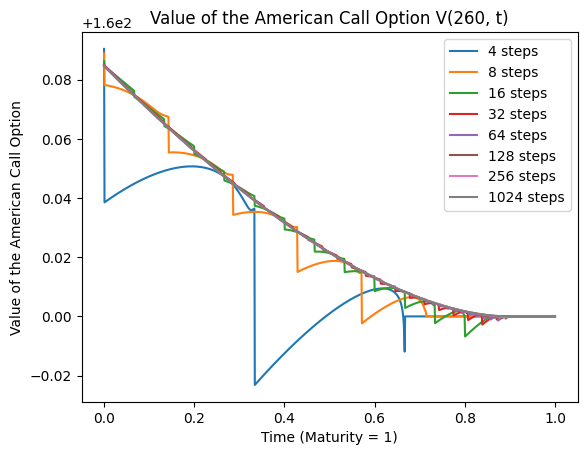

In [10]:
def compute_V(S, t, optimal_exercise_boundary):
    result = M1(S, time_to_maturity - t, strike_price)
    # Use trapezoidal rule to compute \int_t^T Q_1(S,t,u,S_f(u))\,du
    # Find the index of the first time point in the optimal exercise boundary that is greater than t
    idx = np.argmax([pt[0] >= t for pt in optimal_exercise_boundary])
    if (S > optimal_exercise_boundary[idx][1]):
        return S - strike_price
    # Compute the integral using the trapezoidal rule
    for i in range(idx, len(optimal_exercise_boundary) - 1):
        t_i, S_f_i = optimal_exercise_boundary[i]
        t_next, S_f_next = optimal_exercise_boundary[i + 1]
        result += 0.5 * (t_next - t_i) * (Q1(S, t, t_i, S_f_i) + Q1(S, t, t_next, S_f_next))
    return result

S = 260
time_discretization_for_V = np.linspace(0, time_to_maturity, 1024)
V_values = []
for i in range(len(test_results)):
    V_values.append([compute_V(S, t, test_results[i]) for t in time_discretization_for_V])
    plt.plot(time_discretization_for_V, V_values[i], label=f'{test_sizes[i]} steps')
plt.legend()
plt.xlabel('Time (Maturity = 1)')
plt.ylabel('Value of the American Call Option')
plt.title(f'Value of the American Call Option V({S}, t)')
# Save the image to the /images folder
plt.savefig('images/value_of_american_call_option.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
import numpy as np

# Example data structures:
# V_values   = [...]     # list of V curve arrays for each test_size
# test_sizes = [...]     # [32, 64, 128, 256, 512, 1024]

# Use the finest (last) as ground truth
ground_truth = np.array(V_values[-1])

# Step 1: compute all errors
errors = []
for curve in V_values:
    curve_arr = np.array(curve)
    e = np.mean(np.abs(curve_arr - ground_truth))
    errors.append(e)

# Step 2: compute simple ratio rates: Rate[i] = errors[i-1] / errors[i]
rates = [np.nan]  # no rate for the first row
for i in range(1, len(errors)):
    if errors[i] > 0:
        rates.append(errors[i-1] / errors[i])
    else:
        rates.append(np.nan)

# Step 3: print a table
print(f"{'Steps':>6}  {'Error':>14}  {'Rate':>10}")
for N, e, r in zip(test_sizes, errors, rates):
    print(f"{N:6d}  {e:14.12f}  {r:10.4f}")


 Steps           Error        Rate
     4  0.013666072127         nan
     8  0.003012433925      4.5366
    16  0.001109197675      2.7159
    32  0.000402913255      2.7529
    64  0.000164520629      2.4490
   128  0.000062171194      2.6463
   256  0.000021628732      2.8745
  1024  0.000000000000         nan


# American Option as Linear Complimentary Problem

## Operator splitting scheme

In [10]:
n_timesteps=500
n_spacesteps=1000
alpha=0.5
# Parameters
x_domain = np.linspace(0, 500, n_spacesteps)  # Asset prices
t_domain = np.linspace(0, 1, n_timesteps)  # Time from 0 to T
time_interval = 1.0 / n_timesteps

# Initial condition for v at T (payoff for an American call option)
v_T = np.maximum(x_domain - strike_price, 0)
lambda_T = np.zeros(len(x_domain))

# Matrix A setup for the finite difference method
A = np.zeros((len(x_domain), len(x_domain)))
for i in range(len(x_domain)):
    A[i, i] = - ((volatility * i)**2 + risk_free_rate)
    x_value = x_domain[i]
    if i > 0:
        A[i, i - 1] = 0.5 * (((volatility * i)**2 - (risk_free_rate - dividend) * i))
    if i < len(x_domain) - 1:
        A[i, i + 1] = 0.5 * (((volatility * i)**2 + (risk_free_rate - dividend) * i))

# Storage array for the option values at each time step
v_matrix = np.zeros((len(t_domain), len(x_domain)))
v_matrix[-1, :] = v_T  # Set the terminal condition at t = T

# Backward time-stepping
for i in range(len(t_domain) - 2, -1, -1):
    t = t_domain[i]
    
    # Step 1: LU decomposition to find the intermediate step
    A_prime = -1 / time_interval * np.eye(len(x_domain)) + alpha * A
    B = 1 / time_interval * np.eye(len(x_domain)) + (1 - alpha) * A
    intermediate = np.linalg.solve(A_prime, -np.dot(B, v_T) - lambda_T)

    # Step 2: Projection step to enforce the early-exercise constraint
    v_new = np.copy(intermediate)  # Start with the intermediate values as a base
    for j in range(len(x_domain)):
        # Calculate the payoff at this point (for an American call, payoff = max(x - strike_price, 0))
        payoff = max(x_domain[j] - strike_price, 0)
        # Enforce the constraint: v >= payoff
        if v_new[j] + time_interval * lambda_T[j] < payoff:
            v_new[j] = payoff
            lambda_T[j] = max(lambda_T[j] + (1 / time_interval) * (intermediate[j] - v_new[j]), 0)
        else:
            v_new[j] = v_new[j] + time_interval * lambda_T[j]
            lambda_T[j] = 0
    # Update v_T for the next time step
    v_T = v_new
    # Store the new v_T in the matrix for plotting
    v_matrix[i, :] = v_T


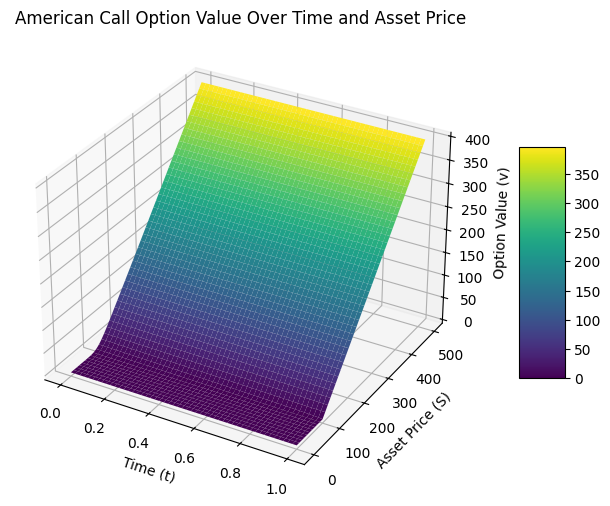

In [45]:
# Define the time and asset price ranges
time_steps = v_matrix.shape[0]
asset_prices = v_matrix.shape[1]

# Create linearly spaced arrays for time and asset prices
t = np.linspace(0, 1, time_steps)
S = np.linspace(0, 500, asset_prices)

# Create a meshgrid
T, S_mesh = np.meshgrid(t, S)

# Transpose v_matrix to match the meshgrid dimensions
V = v_matrix.T
# Create a figure and a 3D axis
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(T, S_mesh, V, cmap='viridis', edgecolor='none')

# Add labels and title
ax.set_xlabel("Time (t)")
ax.set_ylabel("Asset Price (S)")
ax.set_zlabel("Option Value (v)")
ax.set_title("American Call Option Value Over Time and Asset Price")

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Save the figure as a PNG file in the /images folder
plt.savefig('images/operator_american_call_option_value_surface.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


In [ ]:
# Plotting the heatmap
plt.figure(figsize=(12, 6))
plt.imshow(v_matrix.T, extent=[0, 1, 0, 500], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label="Option Value (v)")
plt.xlabel("Time (t)")
plt.ylabel("Asset Price (S)")
plt.title("American Call Option Value Over Time and Asset Price")
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22352\4131611851.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))


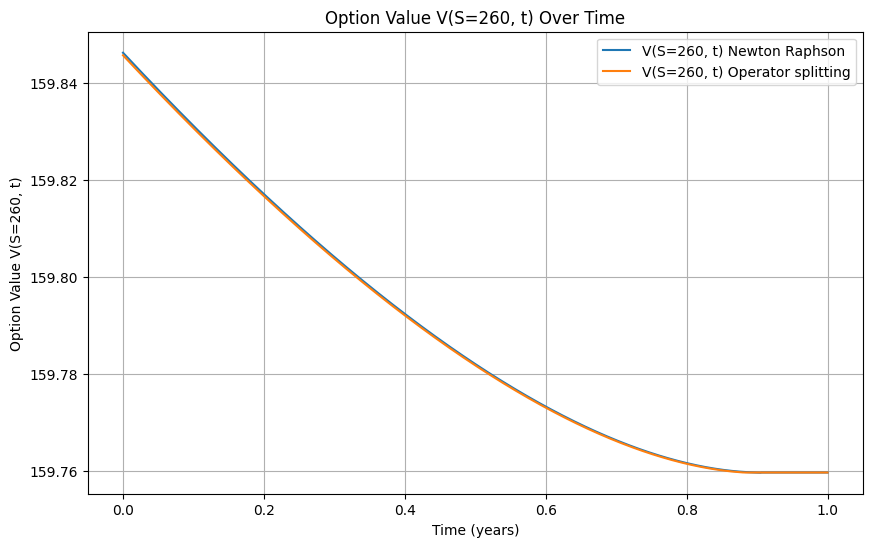

In [47]:
# Find the index in x_domain closest to S = 100
S_target = 260
S_index = np.argmin(np.abs(x_domain - S_target))

# Newton Raphson
V_S_over_time = [compute_V(x_domain[S_index], t, test_results[-1]) for t in time_discretization_for_V]

# Generate time array in years for plotting
time_array = np.linspace(0, time_to_maturity, n_timesteps)
plt.figure(figsize=(10, 6))
plt.plot(time_discretization_for_V, V_S_over_time, label=f'V(S={S_target}, t) Newton Raphson')
plt.plot(t_domain, v_matrix[:, S_index], label=f'V(S={S_target}, t) Operator splitting')
plt.xlabel('Time (years)')
plt.ylabel(f'Option Value V(S={S_target}, t)')
plt.title(f'Option Value V(S={S_target}, t) Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Convergence rate

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9456\4131611851.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))


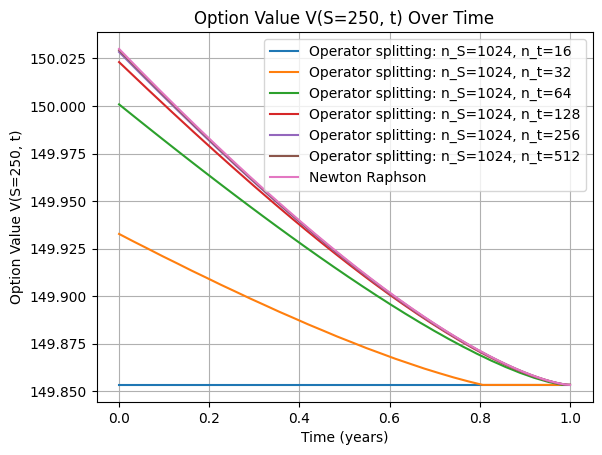

In [11]:
import numpy as np
import matplotlib.pyplot as plt

S_target = 250  # Target asset price for plotting
alpha = 0.5

def thomas_solver(a, b, c, d):
    """
    Solve the tridiagonal system Ax = d
    where:
      - a is the sub-diagonal (length n-1)
      - b is the main diagonal (length n)
      - c is the super-diagonal (length n-1)
      - d is the right-hand side (length n)
    Returns x (length n)
    """
    n = len(b)
    # Copy arrays to avoid modifying the originals
    ac, bc, cc, dc = a.copy(), b.copy(), c.copy(), d.copy()
    
    # Forward sweep
    for i in range(1, n):
        m = ac[i-1] / bc[i-1]
        bc[i] = bc[i] - m * cc[i-1]
        dc[i] = dc[i] - m * dc[i-1]
    
    # Back substitution
    x = np.empty(n)
    x[-1] = dc[-1] / bc[-1]
    for i in range(n-2, -1, -1):
        x[i] = (dc[i] - cc[i] * x[i+1]) / bc[i]
    return x

def operator_splitting(n, m):
    x_domain = np.linspace(0, 300, n)  # Asset prices
    t_domain = np.linspace(0, 1, m)      # Time from 0 to T
    time_interval = 1.0 / m   # Assuming n_timesteps is defined globally

    # Initial condition for v at T (payoff for an American call option)
    v_T = np.maximum(x_domain - strike_price, 0)
    lambda_T = np.zeros(len(x_domain))

    # Matrix A setup for the finite difference method (tridiagonal structure)
    A = np.zeros((len(x_domain), len(x_domain)))
    for i in range(len(x_domain)):
        A[i, i] = - ((volatility * i)**2 + risk_free_rate)
        if i > 0:
            A[i, i - 1] = 0.5 * (((volatility * i)**2 - (risk_free_rate - dividend) * i))
        if i < len(x_domain) - 1:
            A[i, i + 1] = 0.5 * (((volatility * i)**2 + (risk_free_rate - dividend) * i))

    # Preallocate storage for the option values at each time step
    v_matrix = np.zeros((len(t_domain), len(x_domain)))
    v_matrix[-1, :] = v_T  # Terminal condition at t = T

    # Backward time-stepping
    for i in range(len(t_domain) - 2, -1, -1):
        # Step 1: Formulate the system using the TR-BDF splitting
        A_prime = -1 / time_interval * np.eye(len(x_domain)) + alpha * A
        B = 1 / time_interval * np.eye(len(x_domain)) + (1 - alpha) * A
        d = -np.dot(B, v_T) - lambda_T  # Right-hand side for the linear system

        # Extract diagonals from A_prime (tridiagonal)
        diag = np.diag(A_prime)
        lower = np.diag(A_prime, k=-1)
        upper = np.diag(A_prime, k=1)

        # Solve using the Thomas algorithm
        intermediate = thomas_solver(lower, diag, upper, d)

        # Step 2: Projection step to enforce the early-exercise constraint
        v_new = np.copy(intermediate)
        for j in range(len(x_domain)):
            payoff = max(x_domain[j] - strike_price, 0)
            if v_new[j] + time_interval * lambda_T[j] < payoff:
                v_new[j] = payoff
                lambda_T[j] = max(lambda_T[j] + (1 / time_interval) * (intermediate[j] - v_new[j]), 0)
            else:
                v_new[j] = v_new[j] + time_interval * lambda_T[j]
                lambda_T[j] = 0
        v_T = v_new
        v_matrix[i, :] = v_T  # Store for plotting
    return v_matrix

# Example plotting for different discretizations
x_discretizations = [1024,1024,1024,1024,1024,1024]
t_discretization = [16, 32, 64, 128, 256, 512]

# Ensure the following parameters are defined:
# n_timesteps, strike_price, volatility, risk_free_rate, dividend, alpha, S_target

for x_size, t_size in zip(x_discretizations, t_discretization):
    cur_v_matrix = operator_splitting(x_size, t_size)
    cur_x = np.linspace(0, 300, x_size)
    cur_t = np.linspace(0, 1, t_size)
    S_index = np.argmin(np.abs(cur_x - S_target))
    plt.plot(cur_t, cur_v_matrix[:, S_index], label=f'Operator splitting: n_S={x_size}, n_t={t_size}')

#Also plot the ground truth
cur_x = np.linspace(0, 300, 1024)
S_index = np.argmin(np.abs(cur_x - S_target))
V_S_over_time = [compute_V(cur_x[S_index], t, test_results[-1]) for t in time_discretization_for_V]
plt.plot(time_discretization_for_V, V_S_over_time, label='Newton Raphson')

plt.xlabel('Time (years)')
plt.ylabel(f'Option Value V(S={S_target}, t)')
plt.title(f'Option Value V(S={S_target}, t) Over Time')
plt.legend()
plt.grid(True)

plt.savefig('images/operator_splitting_vs_newton_raphson.png', dpi=300, bbox_inches='tight')
plt.show()


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example: Different time discretizations with a fixed spatial discretization
t_discretization = [16, 32, 64, 128, 256, 512]
x_size = 1024  # Fixed spatial discretization

# List to store the MSE results
results = []

for t_size in t_discretization:
    # Run operator splitting method for current time discretization
    cur_v_matrix = operator_splitting(x_size, t_size)
    
    # Construct current grids
    cur_x = np.linspace(0, 300, x_size)
    cur_t = np.linspace(0, 1, t_size)
    
    # Find the index closest to the target asset price S_target
    S_index = np.argmin(np.abs(cur_x - S_target))
    
    # Extract the operator splitting option values over time at S_target
    operator_values = cur_v_matrix[:, S_index]
    
    # Interpolate the ground truth (Newton–Raphson) values to the current time grid
    ground_truth_interp = np.interp(cur_t, time_discretization_for_V, V_S_over_time)
    
    # Compute the Mean Squared Error (MSE)
    mse = np.mean(np.abs(operator_values - ground_truth_interp))
    
    results.append({
        't_discretization': t_size,
        'MSE': mse
    })

# Create a DataFrame for a clear tabular display
df_mse = pd.DataFrame(results)
print(df_mse)


   t_discretization       MSE
0                16  0.074428
1                32  0.044944
2                64  0.010708
3               128  0.002224
4               256  0.000669
5               512  0.000314


## Speed Comparison

In this section, we compare the time it takes for two methods to compute a single V(S, t)

In [13]:
def test_by_n_discretizations(n_discretizations):
    time_discretization = np.linspace(0, time_to_maturity, n_discretizations)
    s_f_list = []
    for _ in range(len(time_discretization)):
        s_f_list.append([0, 0])  # Create a new list for each pair

    s_f_list[-1][1] = max(strike_price, risk_free_rate * strike_price / dividend)
    s_f_list[-1][0] = time_discretization[-1]

    n_steps = len(time_discretization) - 1
    n_steps_to_convergence = []
    for i in range(len(time_discretization) - 2, -1, -1):
        time_passed = i / n_steps
        guess_x = s_f_list[i + 1][1]
        def test_sf(x):
            test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1][1])
            test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
            for j in range(i + 1, len(time_discretization) - 1, 1):
                test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j][1])
                test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1][1])
            return test_result
        def test_sf_derivative(x):
            derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
            derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1][1])
            derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
            for j in range(i + 1, len(time_discretization) - 1):
                derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j][1])
                derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1][1])
            return derivative_result
        
        newton_raphson_result = newton_raphson(test_sf, test_sf_derivative, guess_x)
        s_f_list[i][1] = newton_raphson_result[0]
        s_f_list[i][0] = time_discretization[i]
        n_steps_to_convergence.append(newton_raphson_result[1])
    return s_f_list

def compute_V(S, t, optimal_exercise_boundary):
    result = M1(S, time_to_maturity - t, strike_price)
    # Use trapezoidal rule to compute \int_t^T Q_1(S,t,u,S_f(u))\,du
    # Find the index of the first time point in the optimal exercise boundary that is greater than t
    idx = np.argmax([pt[0] >= t for pt in optimal_exercise_boundary])
    if (S > optimal_exercise_boundary[idx][1]):
        return S - strike_price
    # Compute the integral using the trapezoidal rule
    for i in range(idx, len(optimal_exercise_boundary) - 1):
        t_i, S_f_i = optimal_exercise_boundary[i]
        t_next, S_f_next = optimal_exercise_boundary[i + 1]
        result += 0.5 * (t_next - t_i) * (Q1(S, t, t_i, S_f_i) + Q1(S, t, t_next, S_f_next))
    return result

t_steps = [16, 32, 64, 128, 256, 512, 1024]
x_steps = [256, 256, 512, 512, 1024, 1024, 1024]

# For each x, t, compute the V(260, 0.8) using the Newton-Raphson method. Measure the time taken.
import time

for x_size, t_size in zip(x_steps, t_steps):
    start_time = time.time()
    s_f_list = test_by_n_discretizations(t_size)
    compute_V(260, 0.8, s_f_list)
    elapsed_time = time.time() - start_time
    print(f"Time taken for x={x_size}, t={t_size}: {elapsed_time:.4f} seconds")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4648\4131611851.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))


Time taken for x=256, t=16: 0.0301 seconds
Time taken for x=256, t=32: 0.0815 seconds
Time taken for x=512, t=64: 0.2801 seconds
Time taken for x=512, t=128: 1.1344 seconds
Time taken for x=1024, t=256: 4.7964 seconds
Time taken for x=1024, t=512: 79.8471 seconds
Time taken for x=1024, t=1024: 140.4969 seconds


In [14]:
for x_size, t_size in zip(x_steps, t_steps):
    start_time = time.time()
    operator_splitting(x_size, t_size)
    elapsed_time = time.time() - start_time
    print(f"Time taken for x={x_size}, t={t_size}: {elapsed_time:.4f} seconds")

Time taken for x=256, t=16: 0.0626 seconds
Time taken for x=256, t=32: 0.0940 seconds
Time taken for x=512, t=64: 0.5506 seconds
Time taken for x=512, t=128: 0.6897 seconds
Time taken for x=1024, t=256: 4.9991 seconds
Time taken for x=1024, t=512: 11.1854 seconds
Time taken for x=1024, t=1024: 22.5655 seconds
